In [ ]:
!pip install pandas seaborn scipy plotly pyvis

In [4]:
from elasticsearch import Elasticsearch
import pandas as pd
from collections import Counter
from itertools import product
from itertools import combinations

es = Elasticsearch("http://localhost:9200")
ES_INDEX = "efc_articles_1"

# Fetch all docs (or scroll for >10000)
def fetch_all_articles(index):
    docs = []
    resp = es.search(index=index, size=1000, query={"match_all": {}})
    docs.extend(hit["_source"] for hit in resp["hits"]["hits"])
    return docs

articles = fetch_all_articles(ES_INDEX)
print(articles[0])

{'url': 'https://www.efinancialcareers.com/news/visas-banking-jobs-london', 'title': 'Non-British junior bankers in London are being locked out of jobs', 'date': '22 hours ago', 'author': 'Sarah Butcher', 'body': 'A London recruitment firm is advertising a (comparatively rare in this market) vacancy for an associate to work in technology, media and telecoms M&A. The job comes with a few requirements: you need M&A experience; you also need a right to work in the UK without visa sponsorship.\nGet Morning Coffee ☕ in your inbox. Sign up here.\nFor a growing number of applicants, this is a problem.\nJunior financial services professionals who\'ve had unfettered access to the UK jobs market are feeling the winds of change. Earlier this month, the UK government issued a white paper on regaining control over the immigration system. Among other things, the paper proposed to reduce the length of time students can work on a graduate visa from two years to 18 months and to increase the standard q

In [5]:
import re
# Collect stats
person_counter = Counter()
org_counter = Counter()
person_person_pairs = Counter()
person_org_pairs = Counter()

def normalize_name(name):
    name = re.sub(r"[’'`]", "'", name)  # unify apostrophes
    name = re.sub(r"'s$", "", name)  # remove trailing 's
    name = name.strip()

    # Check alias
    return ALIAS_MAP.get(name, name)

# This removes author names
def clean_people(people_list):
    return [p for p in people_list if not p.startswith("@") and len(p) > 1]

# Manual aliasing
ALIAS_MAP = {
    "Trump": "Donald Trump",
    "Jamie Diamond's": "Jamie Dimon",
    "Jamie Diamond": "Jamie Dimon",
    "Jamie Diamonds": "Jamie Dimon",
    "Dimon": "Jamie Dimon",
    "Donald": "Donald Trump",
}
BAD_ORGS = {"whatsapp", "unsplash"}

for doc in articles:
    if "entities" in doc and "people" in doc["entities"]:
        doc["entities"]["people"] = clean_people(doc["entities"]["people"])

    ents = doc.get("entities", {})
    people = [normalize_name(p) for p in ents.get("people", [])]
    orgs = [normalize_name(o) for o in ents.get("orgs", [])]

    orgs = [o for o in ents.get("orgs", []) if o.lower() not in BAD_ORGS]

    person_counter.update(people)
    org_counter.update(orgs)

    # All person-org co-occurrences in this article
    person_org_pairs.update(product(people, orgs))
    
    if len(people) >= 2:
        # Unique, unordered pairs of people in the article
        person_person_pairs.update(frozenset(pair) for pair in combinations(set(people), 2))


# Convert to DataFrames
df_people = pd.DataFrame(person_counter.most_common(), columns=["Person", "Count"])
df_orgs = pd.DataFrame(org_counter.most_common(), columns=["Organization", "Count"])
df_person_org = pd.DataFrame(person_org_pairs.most_common(), columns=["Pair", "Count"])
df_person_org[["Person", "Organization"]] = pd.DataFrame(df_person_org["Pair"].tolist(), index=df_person_org.index)
df_person_org.drop(columns="Pair", inplace=True)
    
df_person_person = pd.DataFrame(person_person_pairs.items(), columns=["Pair", "Count"])
df_person_person[["Person1", "Person2"]] = pd.DataFrame(df_person_person["Pair"].apply(list).tolist(), index=df_person_person.index)
df_person_person.drop(columns="Pair", inplace=True)

In [6]:
df_orgs

,Organization,Count
0,Goldman Sachs,300
1,JPMorgan,253
2,Citi,206
3,Bloomberg,206
4,Morgan Stanley,180
...,...,...
2449,Englander,1
2450,Revelio Labs,1
2451,SQL,1
2452,Deutsche/Commerzbank,1


In [37]:
df_people

,Person,Count
0,Donald Trump,54
1,Jamie Dimon,44
2,David Solomon,36
3,Ken Griffin,25
4,Jane Fraser,21
...,...,...
3444,Ankit Raj,1
3445,Paul Achleitner,1
3446,Rob Rankin,1
3447,Leslie,1


In [8]:
df_person_org

,Count,Person,Organization
0,38,Donald Trump,Bloomberg
1,37,Jamie Dimon,JPMorgan
2,32,Donald Trump,Goldman Sachs
3,31,David Solomon,Goldman Sachs
4,28,Jamie Dimon,Bloomberg
...,...,...,...
52511,1,Leslie,Cambridge University
52512,1,Leslie,Goldman Sachs
52513,1,Cyrus,Goldman
52514,1,Cyrus,Cambridge University


In [9]:
df_person_person.sort_values("Count", ascending=False)

,Count,Person1,Person2
114,11,David Solomon,Jamie Dimon
117,11,David Solomon,John Waldron
1946,10,Donald Trump,Jamie Dimon
474,6,Jane Fraser,Jamie Dimon
2041,6,Donald Trump,Ken Griffin
...,...,...,...
18748,1,Vertika Agarwal,Dan Wentzell
18749,1,Sanjay Bhasin,Vertika Agarwal
18750,1,Ashley Coombes,Vertika Agarwal
18751,1,Michael Abou-Seif,Vertika Agarwal


## Check the count for Christian Sewing and Donald Trump

In [39]:
filtered_df = df_person_person[
    (df_person_person["Person1"] == "Christian Sewing") |
    (df_person_person["Person2"] == "Christian Sewing")
]
print("Total entries for Christian Sewing", len(filtered_df))

filtered_df = df_person_person[
    (df_person_person["Person1"] == "Donald Trump") |
    (df_person_person["Person2"] == "Donald Trump")
]
print("Total entries for Donald Trump", len(filtered_df))

Total entries for Christian Sewing 130
Total entries for Donald Trump 317


## Analyze basic statistics of the curated data and relationships in it

/tmp/ipykernel_10623/1915019501.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df[x], rotation=45, ha='right')


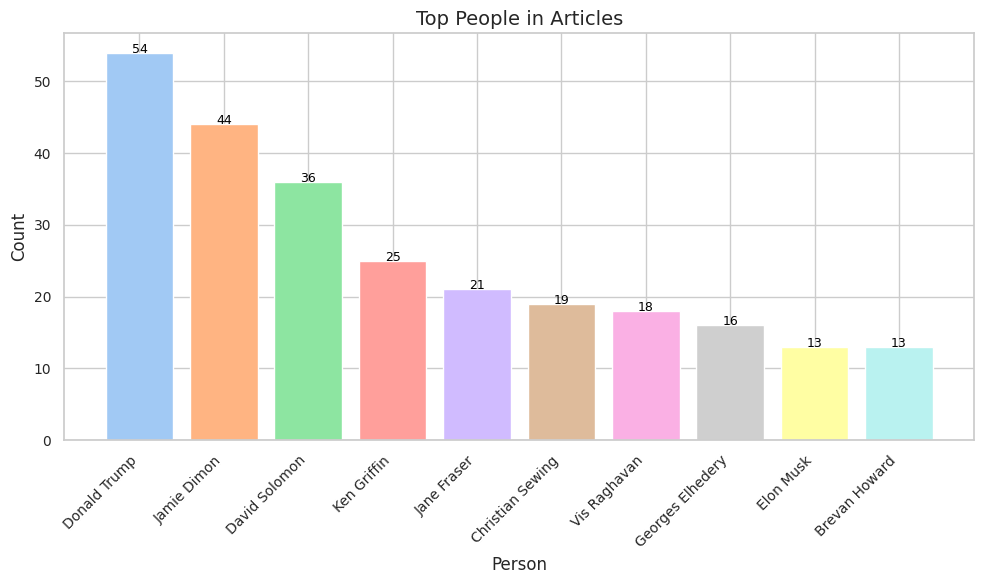

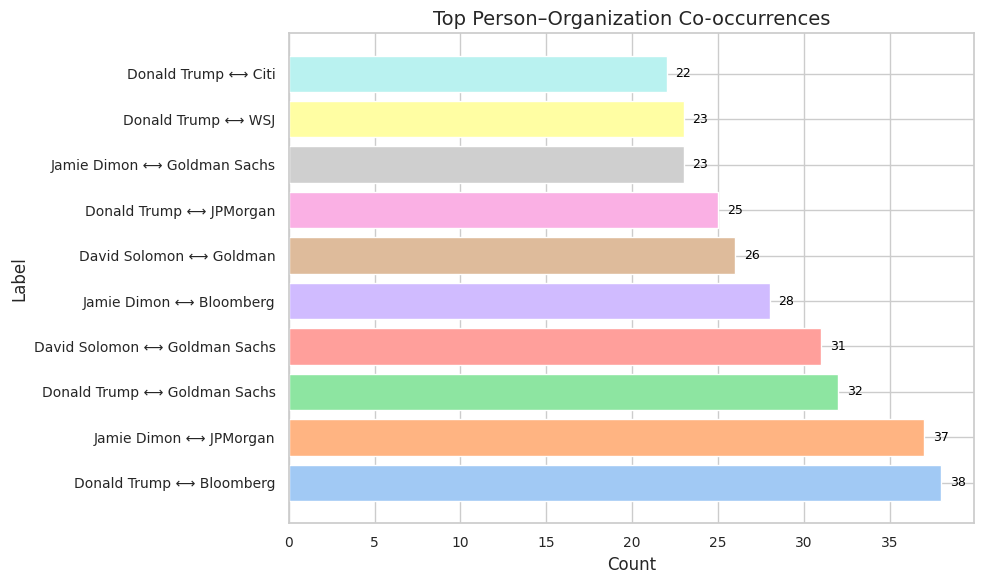

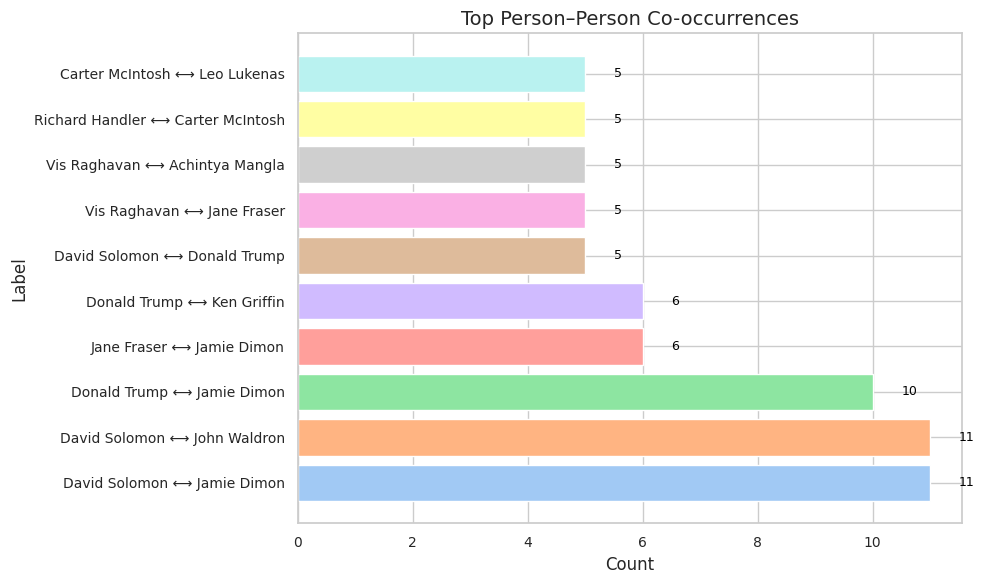

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Use seaborn for styling
# Use pastel palette
pastel_palette = sns.color_palette("pastel")

# Apply global seaborn style
sns.set(style="whitegrid", palette="pastel")
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})


def plot_bar(df, x, y, title, orientation='v', color_palette=pastel_palette):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = color_palette[:len(df)]

    if orientation == 'v':
        bars = ax.bar(df[x], df[y], color=colors)
        ax.set_xlabel(x)
        ax.set_ylabel("Count")
        ax.set_xticklabels(df[x], rotation=45, ha='right')
    else:
        bars = ax.barh(df[x], df[y], color=colors)
        ax.set_xlabel("Count")
        ax.set_ylabel(x)

    ax.set_title(title)
    for bar in bars:
        value = bar.get_width() if orientation == 'h' else bar.get_height()
        xpos = value + 0.5 if orientation == 'h' else bar.get_x() + bar.get_width() / 2
        ypos = bar.get_y() + bar.get_height() / 2 if orientation == 'h' else value + 0.5
        ax.annotate(f'{int(value)}', xy=(xpos, ypos), va='center',
                    ha='left' if orientation == 'h' else 'center',
                    fontsize=9, color='black')
    plt.tight_layout()
    filename = f"figs/general/{title.replace(' ', '_')}.png"
    plt.savefig(filename)
    plt.show()

# 1. Top People
plot_bar(df_people.head(10), x="Person", y="Count", title="Top People in Articles")

# 2. Top Person–Organization Co-occurrences
df_person_org["Label"] = df_person_org["Person"] + " ⟷ " + df_person_org["Organization"]
plot_bar(df_person_org.head(10), x="Label", y="Count", title="Top Person–Organization Co-occurrences", orientation='h')

# 3. Top Person–Person Co-occurrences
df_person_person["Label"] = df_person_person["Person1"] + " ⟷ " + df_person_person["Person2"]
plot_bar(df_person_person.sort_values("Count", ascending=False).head(10), x="Label", y="Count",
         title="Top Person–Person Co-occurrences", orientation='h')

## Create Person-to-person (P2P) network: Based on Raw Co-occurrence

[3, 5, 5, 3, 11, 3, 4, 4, 3, 3, 6, 4, 4, 10, 4, 3, 4, 3, 11, 4, 5, 3, 6, 3, 3, 5, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 5, 4, 3, 3, 3, 3, 5, 4, 3, 3]


/tmp/ipykernel_10623/3920117906.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")  # tab20 has 20 distinct colors


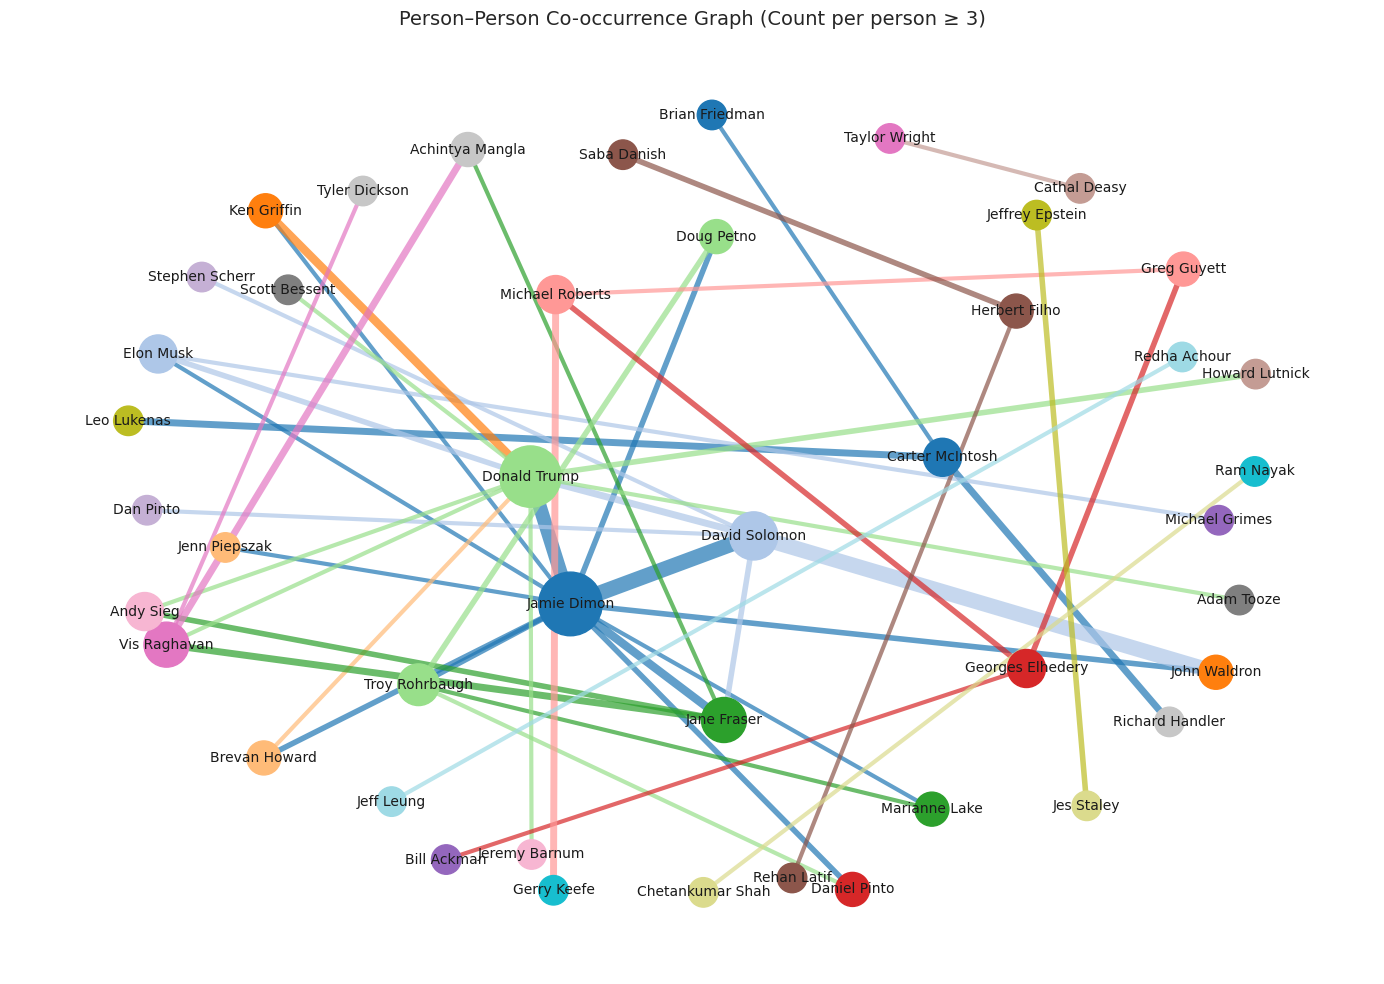

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create undirected graph
G = nx.Graph()
# Add edges with weights
# takes person-person count as weight
for _, row in df_person_person.iterrows():
    G.add_edge(row["Person1"], row["Person2"], weight=row["Count"])

## Filter top N edges by weight
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)[:20]
H = nx.Graph()
min_count = 3
for u, v, d in G.edges(data=True):
    if d["weight"] >= min_count:
        H.add_edge(u, v, weight=d["weight"])


# Node size by degree, edge thickness by weight
k = 2.5
pos = nx.spring_layout(H, seed=42, k=k)  # `k` spreads the layout
# pos = nx.kamada_kawai_layout(H)

edges = H.edges(data=True)
weights = [d["weight"] for _, _, d in edges]

# Scale for visibility
edge_widths = [w for w in weights]  # exaggerate visually
print(weights)
node_sizes = [300 + 150 * H.degree(n) for n in H.nodes()]

# Map node index to a color in the spectrum
# Pick a visually pleasing discrete colormap
cmap = cm.get_cmap("tab20")  # tab20 has 20 distinct colors
nodes = list(H.nodes())
num_nodes = len(nodes)
node_colors = [cmap(i / num_nodes) for i in range(num_nodes)]
node_color_map = dict(zip(nodes, node_colors))
edge_colors = [node_color_map[u] for u, v in H.edges()]

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(H, pos, width=edge_widths, edge_color=edge_colors, alpha=0.7)
nx.draw_networkx_labels(H, pos, font_size=10)


plt.title(f"Person–Person Co-occurrence Graph (Count per person ≥ {min_count})", fontsize=14)
plt.axis("off")
filename = f"figs/p2p_count_total/min_count_{min_count}_spread_{k}.png"
plt.tight_layout()
plt.savefig(filename)
plt.show()

### Run this for interactive visualisation using Pyvis

In [18]:
from pyvis.network import Network
import matplotlib.colors as mcolors

net = Network(height='700px', width='100%', notebook=True)
# Generate a color map (e.g., based on node degree)
degrees = dict(H.degree())
import matplotlib.pyplot as plt
import seaborn as sns

# Use a large pastel palette
pastel_colors = sns.color_palette("pastel", n_colors=len(H.nodes()))
pastel_colors = [mcolors.to_hex(c) for c in pastel_colors]

unique_nodes = list(H.nodes())
node_color_map = {}
for i, node in enumerate(unique_nodes):
    degree = H.degree(node)
    article_count = person_counter.get(node, 0)
    color = pastel_colors[i % len(pastel_colors)]
    node_color_map[node] = color
    title=f"{node} \n Degree: {degree} \n Articles: {article_count}"
    net.add_node(node, label=node, color=color, title=title, size=5 + 2 * article_count)
for u, v, d in H.edges(data=True):
    color = node_color_map.get(u, "#888888")  # fallback if missing
    net.add_edge(u, v, value=d["weight"], color=color, title=f"Weight: {d['weight']}")

net.force_atlas_2based(gravity=-30, central_gravity=0.01, spring_length=100, spring_strength=0.08, damping=0.4)
net.show(f"person_person_graph_min_count_total_{min_count}.html")
# net.write_html(f"person_person_graph_min_count_total_{min_count}.html")

person_person_graph_min_count_total_3.html


## Create Person-to-person (P2P) network: Based on Per-Person Importance

/tmp/ipykernel_10623/2979188566.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")  # tab20 has 20 distinct colors


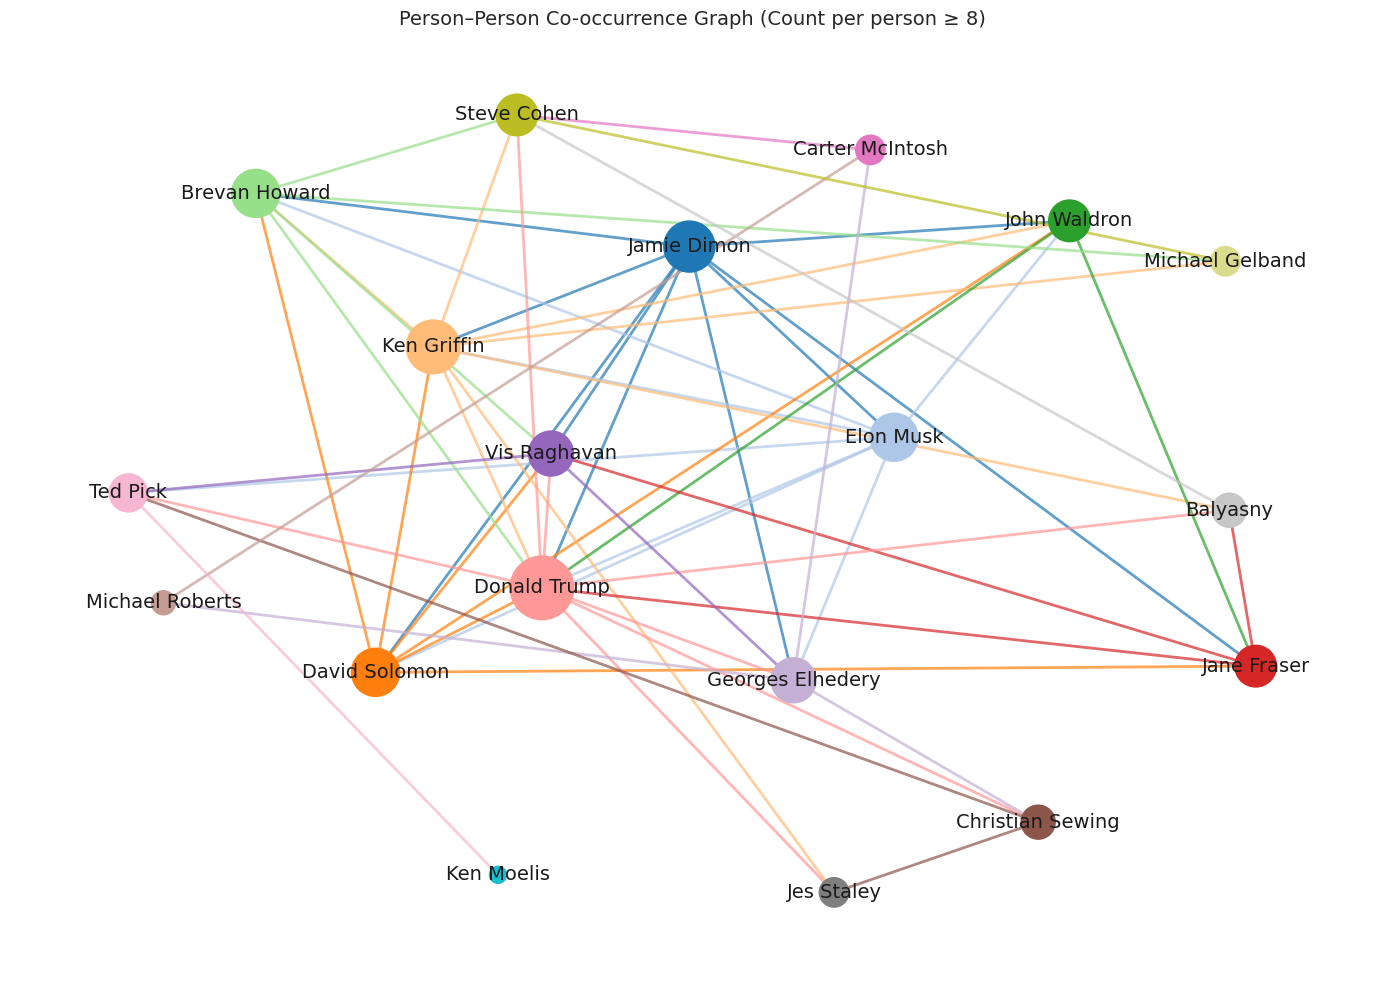

In [20]:
G = nx.Graph()
# takes per person count as weight
for _, pair in df_person_person.iterrows():
    p1, p2 = pair['Person1'], pair['Person2']
    if G.has_edge(p1, p2):
        G[p1][p2]["count"] += 1
    else:
        G.add_edge(p1, p2, weight_1=person_counter[p1], weight_2=person_counter[p2], count=1)
## Filter top N edges by weight
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]["count"], reverse=True)[:20]
H = nx.Graph()
# H.add_edges_from((u, v, {"weight": d["weight"]}) for u, v, d in top_edges)
min_count = 8
for u, v, d in G.edges(data=True):
    if d["weight_1"] >= min_count and d["weight_2"] >= min_count:
        H.add_edge(u, v, weight=d["count"])


# Node size by degree, edge thickness by weight
k = 2.5
pos = nx.spring_layout(H, seed=42, k=k)  # `k` spreads the layout
# pos = nx.kamada_kawai_layout(H)

edges = H.edges(data=True)
weights = [d["weight"] for _, _, d in edges]

# Scale for visibility
edge_widths = [2*w for w in weights]  # exaggerate visually
node_sizes = [150 * H.degree(n) for n in H.nodes()]


import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Pick a visually pleasing discrete colormap
cmap = cm.get_cmap("tab20")  # tab20 has 20 distinct colors
nodes = list(H.nodes())
num_nodes = len(nodes)

# Map node index to a color in the spectrum
node_colors = [cmap(i / num_nodes) for i in range(num_nodes)]
node_color_map = dict(zip(nodes, node_colors))
edge_colors = [node_color_map[u] for u, v in H.edges()]

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(H, pos, width=edge_widths, edge_color=edge_colors, alpha=0.7)
nx.draw_networkx_labels(H, pos, font_size=14)

plt.title(f"Person–Person Co-occurrence Graph (Count per person ≥ {min_count})", fontsize=14)
plt.axis("off")
plt.tight_layout()
filename = f"figs/p2p_count_per_person/min_count_{min_count}_spread_{k}.png"
plt.tight_layout()
plt.savefig(filename)
plt.show()

### Run this for interactive visualisation

In [22]:
from pyvis.network import Network

net = Network(height='700px', width='100%', notebook=True)
# Generate a color map (e.g., based on node degree)
degrees = dict(H.degree())
import matplotlib.pyplot as plt
import seaborn as sns

# Use a large pastel palette
pastel_colors = sns.color_palette("pastel", n_colors=len(H.nodes()))
pastel_colors = [mcolors.to_hex(c) for c in pastel_colors]

unique_nodes = list(H.nodes())
node_color_map = {}
for i, node in enumerate(unique_nodes):
    degree = H.degree(node)
    article_count = person_counter.get(node, 0)
    color = pastel_colors[i % len(pastel_colors)]
    node_color_map[node] = color
    title=f"{node} \n Degree: {degree} \n Articles: {article_count}"
    net.add_node(node, label=node, color=color, title=title, size=5 + 2 * article_count, font={"size": 24})
for u, v, d in H.edges(data=True):
    color = node_color_map.get(u, "#888888")  # fallback if missing
    net.add_edge(u, v, value=d["weight"], color=color, title=f"Weight: {d['weight']}")

# net.show_buttons(filter_=['physics'])  # Optional: enable interaction
# Apply ForceAtlas2
net.force_atlas_2based(gravity=-30, central_gravity=0.01, spring_length=100, spring_strength=0.08, damping=0.4)

net.show(f"person_person_graph_min_count_each_{min_count}.html")
# net.write_html(f"person_person_graph_min_count_each_{min_count}.html")

person_person_graph_min_count_each_8.html


## Create Person-to-organisation (P2O) network

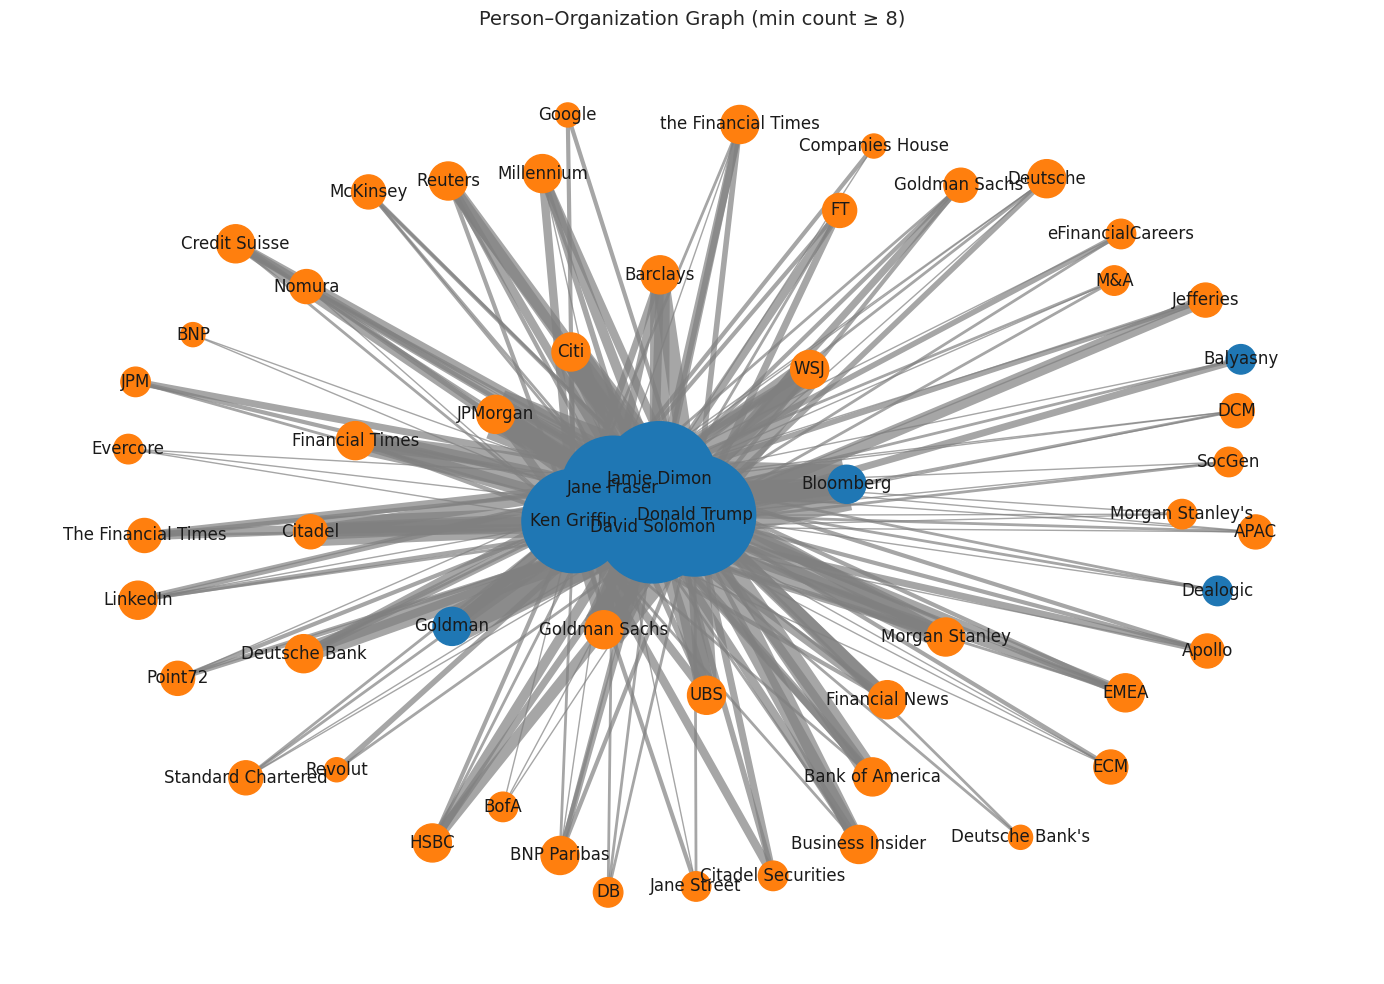

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# === Build bipartite graph ===
G = nx.Graph()

for _, row in df_person_org.iterrows():
    p, o, count = row['Person'], row['Organization'], row['Count']
    if G.has_edge(p, o):
        G[p][o]["count"] += count
    else:
        G.add_edge(p, o,
                   count=count,
                   weight_p=person_counter[p],
                   weight_o=org_counter[o])

# === Filter by node count ===
min_count_p = 20
min_count_o = 20
H = nx.Graph()
for u, v, d in G.edges(data=True):
    if d["weight_p"] >= min_count_p and d["weight_o"] >= min_count_o:
        H.add_edge(u, v, weight=d["count"])

# === Layout & Appearance ===
k = 2.5
pos = nx.spring_layout(H, seed=42, k=k)

# Edge styling
edges = H.edges(data=True)
weights = [d["weight"] for _, _, d in edges]
edge_widths = [w for w in weights]

# Node sizes based on degree
node_sizes = [150 * H.degree(n) for n in H.nodes()]

# Color nodes: people vs orgs
people = {n for n in H.nodes() if n in person_counter}
orgs = set(H.nodes()) - people
node_colors = []
for n in H.nodes():
    node_colors.append("tab:blue" if n in people else "tab:orange")

# === Draw the graph ===
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(H, pos, width=edge_widths, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(H, pos, font_size=12)

plt.title(f"Person–Organization Graph (min count ≥ {min_count})", fontsize=14)
plt.axis("off")
plt.tight_layout()

filename = f"figs/p2o_count_per_node/min_count_{min_count}_spread_{k}.png"
plt.savefig(filename)
print()
# plt.show()

### Run this for interactive visualisation

In [33]:
from pyvis.network import Network

net = Network(height='700px', width='100%', notebook=True)
# Generate a color map (e.g., based on node degree)
degrees = dict(H.degree())
import matplotlib.pyplot as plt
import seaborn as sns

# Use a large pastel palette
pastel_colors = sns.color_palette("pastel", n_colors=len(H.nodes()))
pastel_colors = [mcolors.to_hex(c) for c in pastel_colors]

unique_nodes = list(H.nodes())
node_color_map = {}
for i, node in enumerate(unique_nodes):
    degree = H.degree(node)
    article_count = person_counter.get(node, 0)
    color = pastel_colors[i % len(pastel_colors)]
    node_color_map[node] = color
    title=f"{node} \n Degree: {degree} \n Articles: {article_count}"
    net.add_node(node, label=node, color=color, title=title, size=5 + 2 * article_count)
for u, v, d in H.edges(data=True):
    color = node_color_map.get(u, "#888888")  # fallback if missing
    net.add_edge(u, v, value=d["weight"], color=color, title=f"Weight: {d['weight']}")

# net.show_buttons(filter_=['physics'])  # Optional: enable interaction
# Apply ForceAtlas2
net.force_atlas_2based(gravity=-30, central_gravity=0.01, spring_length=100, spring_strength=0.08, damping=0.4)

net.show("person_graph.html")
# net.write_html("person_graph.html")

person_graph.html


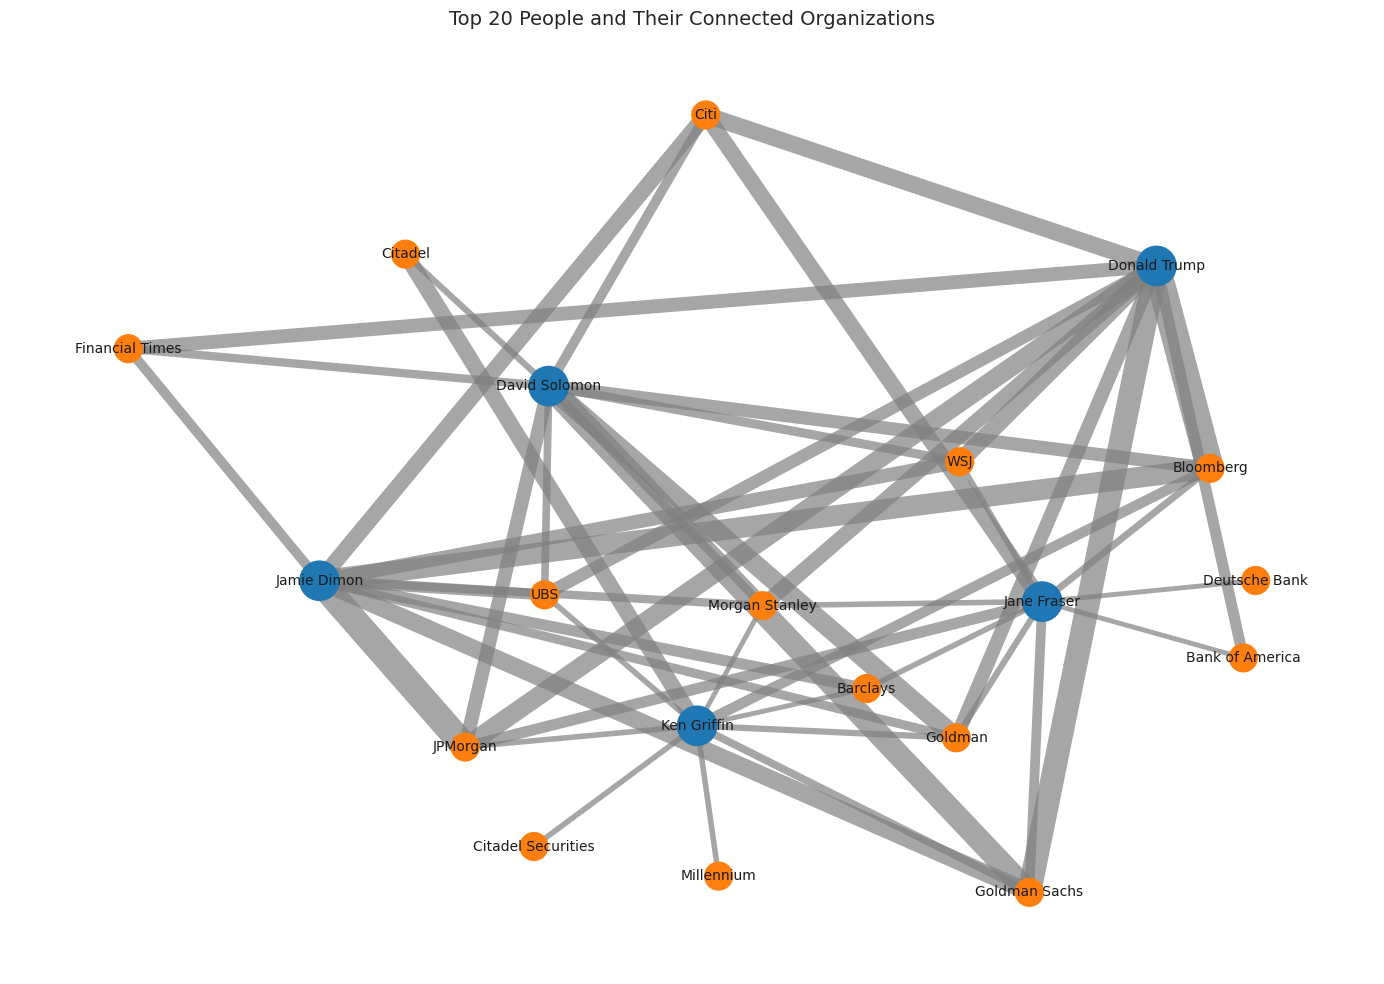

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Build a lookup of person → [(org, count), ...]
person_org_map = defaultdict(list)
for _, row in df_person_org.iterrows():
    person, org, count = row["Person"], row["Organization"], row["Count"]
    person_org_map[person].append((org, count))

# Select top people
TOP_N = 5
top_people = sorted(person_counter, key=person_counter.get, reverse=True)[:TOP_N]
top_people = set(top_people)

# Build reduced graph
H = nx.Graph()

for person in top_people:
    H.add_node(person, type="person", size=person_counter[person])

    # Top 5 orgs for this person
    orgs = sorted(person_org_map[person], key=lambda x: x[1], reverse=True)[:10]
    for org, count in orgs:
        H.add_node(org, type="org", size=org_counter.get(org, 1))
        H.add_edge(person, org, weight=count)

# Layout (kamada_kawai spreads nicely for star structure)
pos = nx.kamada_kawai_layout(H)

# Node styling
node_colors = []
node_sizes = []
for node in H.nodes(data=True):
    if node[1]["type"] == "person":
        node_colors.append("tab:blue")
        node_sizes.append(800)
    else:
        node_colors.append("tab:orange")
        node_sizes.append(400)

# Edge styling
weights = [H[u][v]["weight"] for u, v in H.edges()]
edge_widths = [1 + 0.5 * w for w in weights]

# Draw
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(H, pos, width=edge_widths, edge_color="gray", alpha=0.7)
nx.draw_networkx_labels(H, pos, font_size=10)

plt.title("Top 20 People and Their Connected Organizations", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.savefig("top_people_org_starburst.png")
plt.show()

### Run this for interactive visualisation

In [36]:
from pyvis.network import Network

# Build pyvis net
net = Network(height="800px", width="100%", notebook=True, directed=False)
net.force_atlas_2based(gravity=-60, central_gravity=0.01, spring_length=100, spring_strength=0.08, damping=0.4)

# Generate unique pastel color for each person
import itertools
pastel_colors = itertools.cycle([mcolors.to_hex(c) for c in sns.color_palette("pastel", n_colors=50)])

node_color_map = {}
unique_nodes = list(H.nodes(data=True))

for node, data in unique_nodes:
    if data["type"] == "person":
        color = next(pastel_colors)
        node_color_map[node] = color
        net.add_node(
            node, label=node, color=color, shape="dot",
            size=data["size"] * 2.5, title=f"Person: {node}", font={"size": 40},
        )
    else:
        net.add_node(
            node, label=node, color="orange", shape="box", font={"size": 40},
            size=data["size"], title=f"Org: {node}"
        )

# Add edges
for u, v, d in H.edges(data=True):
    person = u if H.nodes[u]["type"] == "person" else v
    edge_color = node_color_map.get(person, "#888888")
    net.add_edge(u, v, value=d["weight"]*2, color=edge_color, title=f"Mentions: {d['weight']}")

# Save & render
# net.show("person_graph.html")
net.show_buttons(filter_=['physics'])
net.show(f"top_people_org_starburst_top_{TOP_N}.html")
# net.save_graph(f"top_people_org_starburst_top_{TOP_N}.html")


top_people_org_starburst_top_5.html
